In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import rosbag

import os

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

DEFAULT_FIG_SIZE = (10,10)
APT_ROOT_BAG_PATH = '/home/mitchell/magellan-data/apartment/3-22-2020'

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def extract_imu_dataframe(bag_path):
    bag = rosbag.Bag(bag_path, 'r')
    
    data_points = []
    first_point = True
    previous_time = 0
    for topic, msg, timestamp in bag.read_messages(topics=['/arduino_sensor_reader/output_topic_imu']):
        data_point = {}
        data_point['timestamp'] = timestamp.to_nsec()
        
        if (first_point):
            data_point['dt'] = 0
            first_point = False
        else:
            data_point['dt'] = data_point['timestamp'] - previous_time
        previous_time = data_point['timestamp']
        
        
        data_point['lin_x'] = msg.imu.linear_acceleration.x
        data_point['lin_y'] = msg.imu.linear_acceleration.y
        data_point['lin_z'] = msg.imu.linear_acceleration.z
        
        data_point['roll_vel'] = msg.imu.angular_velocity.x
        data_point['pitch_vel'] = msg.imu.angular_velocity.y
        data_point['yaw_vel'] = msg.imu.angular_velocity.z
        
        data_point['mag_x'] = msg.magnetometer.x
        data_point['mag_y'] = msg.magnetometer.y
        data_point['mag_z'] = msg.magnetometer.z
        
        data_point['temperature'] = msg.temperature
        
        data_points.append(data_point)
    
    columns = ['timestamp', 'dt', 'lin_x', 'lin_y', 'lin_z', 'roll_vel', 'pitch_vel', 'yaw_vel']
    columns += ['mag_x', 'mag_y', 'mag_z', 'temperature']
    return pd.DataFrame(data_points, columns=columns)

def extract_gps_dataframe(bag_path):
    bag = rosbag.Bag(bag_path, 'r')
    
    data_points = []
    first_point = True
    previous_time = 0
    for topic, msg, timestamp in bag.read_messages(topics=['/arduino_sensor_reader/output_topic_gps']):
        data_point = {}
        data_point['timestamp'] = timestamp.to_nsec()
        
        if (first_point):
            data_point['dt'] = 0
            first_point = False
        else:
            data_point['dt'] = data_point['timestamp'] - previous_time
        previous_time = data_point['timestamp']
        
        data_point['latitude'] = msg.latitude
        data_point['longitude'] = msg.longitude
        data_point['altitude'] = msg.altitude
        
        data_points.append(data_point)
    
    return pd.DataFrame(data_points, columns=['timestamp', 'dt', 'latitude', 'longitude', 'altitude'])
        
def extract_rosbags():
    file_header = 'still_5min_noimage_'
    file_footer = '.bag'
    files = [f for f in os.listdir(APT_ROOT_BAG_PATH) if os.path.isfile(os.path.join(APT_ROOT_BAG_PATH, f))]
    files = [f for f in files if f.startswith(file_header) and f.endswith(file_footer)]
    
    output_imu = {}
    output_gps = {}
    for file in files:
        identifier = file.replace(file_header, '').replace(file_footer, '')
        file_path = os.path.join(APT_ROOT_BAG_PATH, file)
        output_imu[identifier] = extract_imu_dataframe(file_path)
        output_gps[identifier] = extract_gps_dataframe(file_path)
        
    output = {}
    output['imu'] = output_imu
    output['gps'] = output_gps
    
    return output

datasets = extract_rosbags()
datasets['gps']['right'].head()

,timestamp,dt,latitude,longitude,altitude
0,1584920983201988191,0,122.308052,-47.620373,112.699997
1,1584920983382985815,180997624,122.308052,-47.620373,112.699997
2,1584920983604063605,221077790,122.308052,-47.620373,112.699997
3,1584920983783851889,179788284,122.308052,-47.620373,112.699997
4,1584920984005817475,221965586,122.308052,-47.620373,112.699997


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


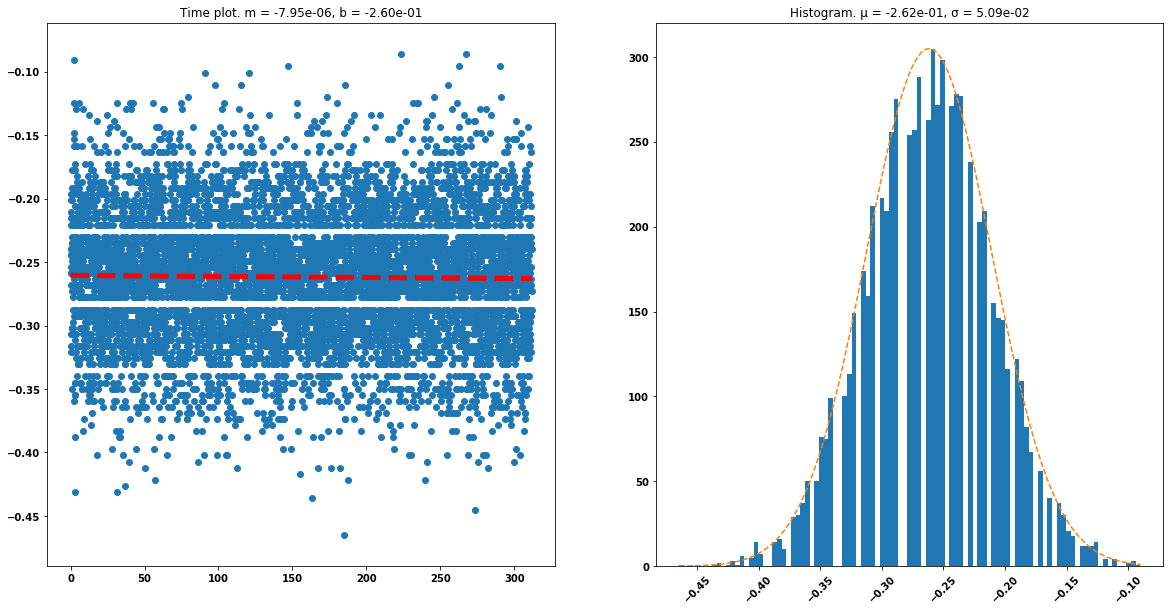

In [3]:
def histogram_and_time_plot(df, target_col):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(2*DEFAULT_FIG_SIZE[0], DEFAULT_FIG_SIZE[1]))
    
    timestamps = (df['timestamp'] - np.min(df['timestamp'])) / (10 ** 9)
    data = df[target_col]
    
    coefficients = np.polyfit(timestamps, data, 1)
    line_of_best_fit = (timestamps * coefficients[0]) + coefficients[1]
    
    axes[0].scatter(timestamps, data, label=target_col)
    axes[0].plot(timestamps, line_of_best_fit, 'r--', linewidth=5)
    axes[0].set_title('Time plot. m = {0:.2e}, b = {1:.2e}'.format(coefficients[0], coefficients[1]))
    axes[0].ticklabel_format(useOffset=False, style='plain')
    
    num_bins = 100
    bins = np.arange(np.min(data), np.max(data), (np.max(data)-np.min(data)) / num_bins)
    
    mean = np.mean(data)
    stdev = np.std(data)
    
    hist_output = axes[1].hist(data, bins=bins, label='Measurements')
    fit_gaussian = np.max(np.abs(hist_output[0])) * np.exp(-0.5 * (((bins - mean) / stdev) ** 2))
    
    axes[1].set_title('Histogram. μ = {0:.2e}, σ = {1:.2e}'.format(mean, stdev))
    axes[1].plot(bins, fit_gaussian, '--')
    axes[1].ticklabel_format(useOffset=False, style='plain')
    for tick in axes[1].get_xticklabels():
        tick.set_rotation(45)
    
    plt.show()
    
histogram_and_time_plot(datasets['imu']['right'], 'lin_x')

In [7]:
def make_comparison_chart(dfs, columns):
    samples = ['left', 'right', 'up', 'down']
    
    output_data_frame = []
    for column in columns:
        for sample in samples:
            row = {}
            row['column'] = column
            row['dataset'] = sample
            df = dfs[sample]

            timestamps = (df['timestamp'] - np.min(df['timestamp'])) / (10 ** 9)
            data = df[column]

            coefficients = np.polyfit(timestamps, data, 1)
            row['m'] = coefficients[0]
            row['b'] = coefficients[1]
            row['mean'] = np.mean(data)
            row['stdev'] = np.std(data)

            output_data_frame.append(row)
    
    return pd.DataFrame(output_data_frame, columns=['column', 'dataset', 'm', 'b', 'mean', 'stdev'])

columns = ['lin_x', 'lin_y', 'lin_z', 'roll_vel', 'pitch_vel', 'yaw_vel', 'mag_x', 'mag_y', 'mag_z', 'temperature']
comparison = make_comparison_chart(datasets['imu'], columns)
comparison

,column,dataset,m,b,mean,stdev
0,lin_x,left,3.464385e-06,-0.096072,-0.095532,0.048525
1,lin_x,right,-7.950325e-06,-0.260472,-0.261711,0.050867
2,lin_x,up,5.621070e-05,-0.169714,-0.160953,0.058875
3,lin_x,down,-2.008739e-05,-0.186834,-0.189966,0.048841
4,lin_y,left,-4.643706e-06,0.008649,0.007925,0.048474
5,lin_y,right,-5.684098e-06,0.137628,0.136742,0.049767
6,lin_y,up,-1.300131e-05,0.184412,0.182385,0.048851
7,lin_y,down,1.628455e-05,0.042086,0.044625,0.051363
8,lin_z,left,1.024666e-05,9.632346,9.633944,0.076657
9,lin_z,right,7.807421e-06,9.691527,9.692743,0.081286


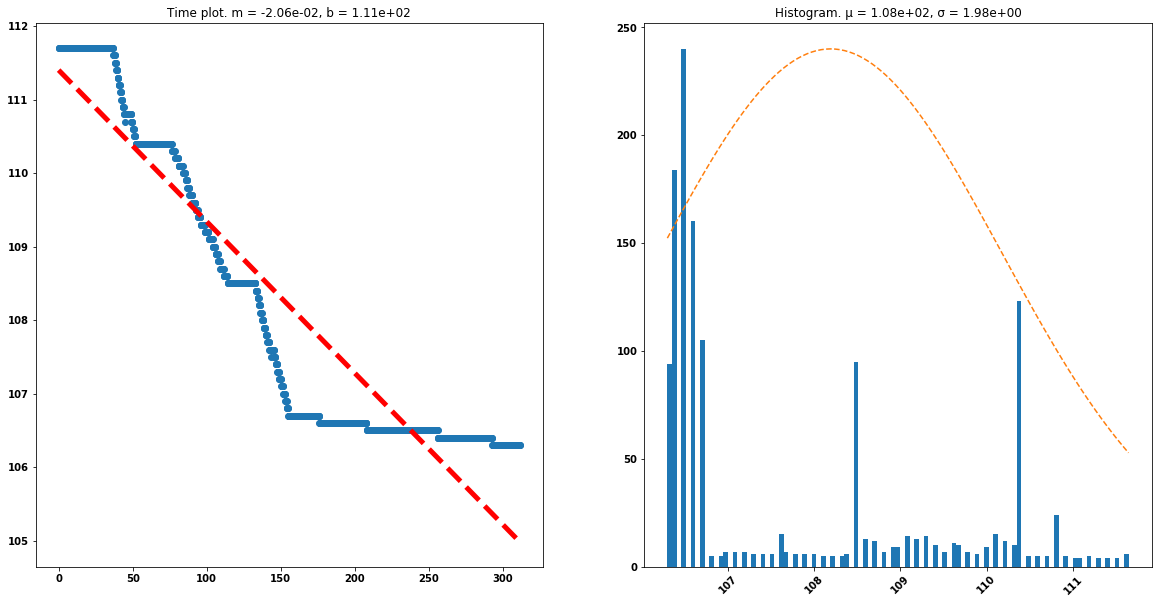

In [5]:
histogram_and_time_plot(datasets['gps']['up'], 'altitude')

In [6]:
columns = ['latitude', 'longitude', 'altitude']
comparison = make_comparison_chart(datasets['gps'], columns)
comparison

,column,dataset,m,b,mean,stdev
0,latitude,left,-1.584814e-07,122.307974,122.307949,3.756941e-05
1,latitude,right,5.703506e-08,122.308042,122.308051,6.289812e-06
2,latitude,up,5.349155e-07,122.308091,122.308174,7.318045e-05
3,latitude,down,1.392089e-07,122.307963,122.307985,1.484931e-05
4,longitude,left,-1.861340e-08,-47.620335,-47.620338,1.221045e-05
5,longitude,right,1.294716e-09,-47.620369,-47.620369,5.066180e-07
6,longitude,up,-1.041974e-07,-47.620367,-47.620383,1.479747e-05
7,longitude,down,6.659604e-08,-47.620312,-47.620301,1.172966e-05
8,altitude,left,-3.672333e-03,106.327143,105.755007,3.607298e-01
9,altitude,right,3.081327e-04,112.581947,112.629954,1.032235e-01
